In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile

with zipfile.ZipFile('/content/drive/My Drive/extracted_images.zip') as z:
  z.extractall('/content/drive/My Drive/extracted_images')

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from skimage.io import imread, imshow
from sklearn.model_selection import train_test_split

random_seed = 1

In [0]:
sym_to_int_dict = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    'cos': 10,
    'div': 11,
    'infty': 12,
    'int': 13,
    'log': 14,
    'pi': 15,
    'sin': 16,
    'sqrt': 17,
    'tan': 18,
    'x': 19,
    'y': 20,
    '-': 21,
    '(': 22,
    ')': 23,
    '+': 24
}

In [4]:
key_list = list(sym_to_int_dict.keys())
print(key_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'cos', 'div', 'infty', 'int', 'log', 'pi', 'sin', 'sqrt', 'tan', 'x', 'y', '-', '(', ')', '+']


In [0]:
TRAIN_PATH = '/content/drive/My Drive/extracted_images/extracted_images/'
train_files = next(os.walk(TRAIN_PATH))[1]

In [0]:
total_img = 0
for id_ in train_files:
  file_path = TRAIN_PATH + id_ + '/'
  img_list = next(os.walk(file_path))[2]
  for img_name in img_list:
    total_img += 1

In [7]:
print(total_img)

54396


In [8]:
X_train = np.zeros((total_img, 45, 45, 1), dtype = np.uint8)
Y_train = np.zeros((total_img, 1), dtype = np.int32)

print('Getting training data...')
sys.stdout.flush()

count = 0
for n, id_ in tqdm(enumerate(train_files), total = len(train_files)):
  label = -1
  for i in key_list:
    if id_ == i:
      label = id_
      break
  
  file_path = TRAIN_PATH + id_ + '/'
  img_list = next(os.walk(file_path))[2]
  for img_name in img_list:
    img_path = file_path + img_name
    img = imread(img_path)
    img = np.expand_dims(img, 2)
    X_train[count] = img
    Y_train[count] = sym_to_int_dict[str(label)]
    count += 1

print('Done!')

Getting training data...


100%|██████████| 25/25 [01:32<00:00,  3.71s/it]

Done!


In [0]:
train = torch.zeros((total_img, 1, 45, 45))
label = torch.zeros((total_img, 1))
for n in range(total_img):
  img_tensor = TF.to_tensor(TF.to_pil_image(X_train[n]))
  train[n] = img_tensor

  label_tensor = torch.from_numpy(Y_train[n])
  label[n] = label_tensor

In [10]:
print(train.shape)
print(label.shape)

torch.Size([54396, 1, 45, 45])
torch.Size([54396, 1])


In [0]:
train, test, label_train, label_test = train_test_split(train, label, test_size = 0.2, random_state = random_seed)

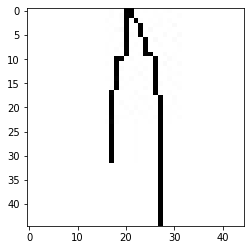

tensor([1.])


In [13]:
img = np.array(TF.to_pil_image(train[40000]))
plt.imshow(img, cmap = 'gray')
plt.show()

print(label_train[40000])

In [0]:
train_dataset = TensorDataset(train, label_train)
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)

val_dataset = TensorDataset(test, label_test)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)

In [0]:
def conv_block(dropout, drop_val, in_channels, out_channels, *args, **kwargs):
  if dropout:
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, *args, **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.Dropout2d(drop_val),
        nn.ReLU()
    )

  else:
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, *args, **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [0]:
class sym_rec(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_layers = nn.Sequential(
        conv_block(False, 0, 1, 32, kernel_size = (5, 5), stride = 1, padding = 2),
        conv_block(True, 0.25, 32, 32, kernel_size = (5, 5), stride = 1, padding = 2),
        nn.MaxPool2d(kernel_size = (2, 2)),
        conv_block(False, 0, 32, 64, kernel_size = (5, 5), stride = 1, padding = 2),
        conv_block(True, 0.25, 64, 64, kernel_size = (5, 5), stride = 1, padding = 2),
        nn.MaxPool2d(kernel_size = (2, 2), stride = 2),
        conv_block(False, 0, 64, 128, kernel_size = (3, 3), stride = 1, padding = 1),
        conv_block(True, 0.25, 128, 128, kernel_size = (3, 3), stride = 1, padding = 1),
        nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
    )

    self.lin_layers = nn.Sequential(
        nn.Linear(3200, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(256, 25),
        nn.Sigmoid()
    )

  def forward(self, x):

    x = self.conv_layers(x)
    
    x = x.view(-1, 3200)

    out = self.lin_layers(x)

    return x

In [17]:
model = sym_rec()
model = model.float()
model = model.to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

sym_rec(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout2d(p=0.25, inplace=False)
      (3): ReLU()
    )
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [0]:
opt = optim.Adam(model.parameters(), lr = 0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, patience = 1, verbose = True)
loss_func = nn.CrossEntropyLoss()

In [0]:
def fit(model, epochs, opt, loss_func, train_loader, valid_loader):

    for epoch in range(epochs):
        #Going into training mode
        model.train()
        
        train_loss = 0
        train_acc = 0
       
        for xb, yb in train_loader:
            xb = xb.to(device)   #Passing the input mini-batch to the GPU
            yb = yb.to(device)   #Passing the label mini-batch to the GPU
            yb = yb.long()
            opt.zero_grad()      #Setting the grads to zero to avoid accumulation of gradients
            out = model(xb.float())
            loss = loss_func(out, yb.squeeze())    #Squeezing yb so it has dimensions (minibatch_size,)
            train_loss += loss
            train_pred = torch.argmax(out, dim = 1)
            train_pred = train_pred.reshape(train_pred.size()[0], 1) #Setting train_pred to have shape (minibatch_size, 1)
            train_acc += (train_pred == yb).float().mean()
            
            loss.backward()
            opt.step()
        
        lr_scheduler.step(train_loss/len(train_loader))   #Setting up lr decay  
        
        model.eval()            #Going into eval mode                            
        with torch.no_grad():   #No backprop
            valid_loss = 0
            valid_acc = 0
            
            for xb, yb in valid_loader:
                xb = xb.to(device)  
                yb = yb.to(device)
                yb = yb.long()
                cv_out = model(xb.float())
                valid_loss += loss_func(cv_out, yb.squeeze())
                valid_pred = torch.argmax(cv_out, dim = 1)
                valid_pred = valid_pred.reshape(valid_pred.size()[0], 1)
                valid_acc += (valid_pred == yb).float().mean()
        
        print("Epoch ", epoch, " Training Loss: ", train_loss/len(train_loader), "CV Loss: ", valid_loss/len(valid_loader))
        print("Training Acc: ", train_acc/len(train_loader), "CV Acc: ", valid_acc/len(valid_loader))

In [20]:
fit(model, 150, opt, loss_func, train_loader, val_loader)

Epoch  0  Training Loss:  tensor(3.6556, device='cuda:0', grad_fn=<DivBackward0>) CV Loss:  tensor(1.6046, device='cuda:0')
Training Acc:  tensor(0.4779, device='cuda:0') CV Acc:  tensor(0.7904, device='cuda:0')
Epoch  1  Training Loss:  tensor(2.7125, device='cuda:0', grad_fn=<DivBackward0>) CV Loss:  tensor(1.0259, device='cuda:0')
Training Acc:  tensor(0.6048, device='cuda:0') CV Acc:  tensor(0.8598, device='cuda:0')
Epoch  2  Training Loss:  tensor(2.4909, device='cuda:0', grad_fn=<DivBackward0>) CV Loss:  tensor(1.6700, device='cuda:0')
Training Acc:  tensor(0.6387, device='cuda:0') CV Acc:  tensor(0.6752, device='cuda:0')
Epoch  3  Training Loss:  tensor(2.3923, device='cuda:0', grad_fn=<DivBackward0>) CV Loss:  tensor(1.7648, device='cuda:0')
Training Acc:  tensor(0.6543, device='cuda:0') CV Acc:  tensor(0.6745, device='cuda:0')
Epoch  4  Training Loss:  tensor(2.3675, device='cuda:0', grad_fn=<DivBackward0>) CV Loss:  tensor(0.6300, device='cuda:0')
Training Acc:  tensor(0.6641